In [86]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import torch.nn.functional as Func
import torchvision as tv
import albumentations as A

import matplotlib.pyplot as plt

from tqdm import tqdm

import cv2
import numpy as np

In [87]:
torch.cuda.is_available()
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [88]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize((80,80)),
    tv.transforms.ToTensor()
])

In [89]:
path = 'C:/Users/kryzh/dataset/training_set/training_set'
dataset = tv.datasets.ImageFolder(root=path, transform=transforms)

torch.Size([3, 80, 80])

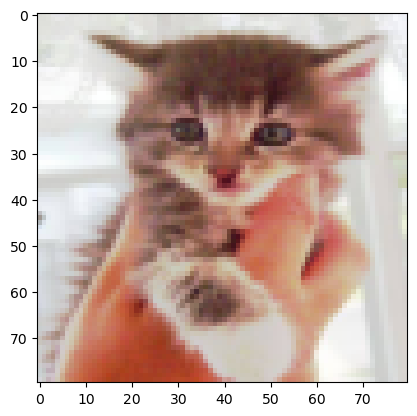

In [90]:
plt.imshow(dataset[2][0].numpy().transpose((1,2,0)))
dataset[2][0].shape

In [91]:
dataloader=torch.utils.data.DataLoader(dataset, batch_size=16,shuffle=True, num_workers = 4)

In [92]:
class CNA(nn.Module):
    def __init__(self, in_nc=32,out_nc=32):
        super().__init__()

        self.conv=nn.Conv2d(in_nc,out_nc,kernel_size=3,padding=1) #128 128
        self.norm=nn.BatchNorm2d(out_nc)
        self.act = nn.ReLU()

    def forward(self, x):
        out=self.conv(x)
        out=self.norm(out)
        out=self.act(out)
        
        return out
    
net = CNA()
net = net.to(device)

In [93]:
class SimpleConvNet(nn.Module):
    def __init__(self, base_nc=32):
        super().__init__()

        # self.flatten =nn.Flatten()
        # self.Linear1=nn.Linear(784,100)
        # self.act=nn.Sigmoid()
        # self.LInear2=nn.Linear(100,10)
        maxpool=nn.MaxPool2d(2,2)
        avgpool=nn.AdaptiveAvgPool2d((1,1))
        act = nn.ReLU()
        Linear1 = nn.Linear(4*base_nc,2)

        flatten = nn.Flatten()

        cna1_1=CNA(3,base_nc)
        cna1_2=CNA(base_nc,base_nc)

        cna2_1=CNA(base_nc,2*base_nc)
        cna2_2=CNA(2*base_nc, 2*base_nc)

        cna3_1=CNA(2*base_nc,4*base_nc)
        cna3_2=CNA(4*base_nc,4*base_nc)
        
        cna4_1=CNA(4*base_nc,4*base_nc)
        cna4_2=CNA(4*base_nc,4*base_nc)
        
        cna5_1=CNA(4*base_nc,4*base_nc)
        cna5_2=CNA(4*base_nc,4*base_nc)

        
        self.model = nn.Sequential(
            cna1_1,cna1_2,maxpool,
            cna2_1,cna2_2,maxpool,
            cna3_1,cna3_2,maxpool,
            cna4_1,cna4_2,maxpool,
            cna5_1,cna5_2,avgpool,
            flatten,Linear1
        )

    def forward(self, x):
        
        return self.model(x)
    


In [94]:
vggNet=tv.models.vgg.vgg19(weights=tv.models.VGG19_Weights)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [95]:
vggNet

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [96]:
classifier=nn.Sequential(
    nn.Linear(25088,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)
vggNet.classifier=classifier
#net = SimpleConvNet()
net=vggNet
net = net.to(device)

In [97]:
def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [98]:
print(count_parameters(net))

22543586


In [99]:
#loss_fn=nn.BCEWithLogitsLoss().to(device)
loss_fn = nn.CrossEntropyLoss()
#loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(net.classifier.parameters(),lr=1e-4, betas=(0.9, 0.999))

In [100]:
def get_accuracy(pred, label):
    answer = pred.detach().numpy().argmax(1) == label.numpy().argmax(1) 
    return answer.mean()


In [101]:
epochs=10
for epoch in range(epochs):
    loss_val=0
    acc_val=0

    for sample in tqdm(dataloader):
        img,label = sample

        label = label.to(device)
        label = Func.one_hot(label, num_classes=2).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
        img = img.to(device)
        
        optimizer.zero_grad()
        pred = net (img)

        loss = loss_fn(pred, label)
        loss.backward()

        optimizer.step()
        
        loss_val+=loss.item()
        acc_val += get_accuracy(pred.cpu(), label.cpu())
    loss_val /= len(dataloader)
    acc_val /= len(dataloader)
    print("loss=",loss_val ,"accruracy=",acc_val)
    

100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:26<00:00, 18.67it/s]


loss= 0.3366883409222562 accruracy= 0.8487774451097805


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:26<00:00, 19.01it/s]


loss= 0.25963227789172394 accruracy= 0.8878493013972056


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:26<00:00, 18.99it/s]


loss= 0.21702319528803438 accruracy= 0.909181636726547


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:26<00:00, 18.98it/s]


loss= 0.1814004599438337 accruracy= 0.925249500998004


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:26<00:00, 18.97it/s]


loss= 0.13829755749341524 accruracy= 0.9448602794411177


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:26<00:00, 18.99it/s]


loss= 0.0992856400362597 accruracy= 0.9647954091816368


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:26<00:00, 18.97it/s]


loss= 0.0741053975887593 accruracy= 0.9760479041916168


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:26<00:00, 18.97it/s]


loss= 0.048343443951918974 accruracy= 0.9869011976047904


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:26<00:00, 18.99it/s]


loss= 0.024691427787288348 accruracy= 0.9950099800399201


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:26<00:00, 18.96it/s]

loss= 0.025200452388572648 accruracy= 0.9935129740518962


In [102]:
path = 'C:/Users/kryzh/dataset/test_set/test_set'
testset = tv.datasets.ImageFolder(root=path, transform=transforms)


In [103]:
testloader=torch.utils.data.DataLoader(testset, batch_size=1,shuffle=True, num_workers = 4)

In [104]:
acc_val=0
for sample in testloader:
    img,label = sample
    #plt.imshow(img.numpy().transpose((1,2,0)))
    img = img.to(device)
    label = label.to(device)
    label = Func.one_hot(label, num_classes=2).float()
    label = label.unsqueeze(1)
    pred = net(img)
    acc_val += get_accuracy(pred.cpu(), label.cpu())
    #print(acc_val)
    #print( pred,label)
print(acc_val/len(testloader))

0.47602570439940683


In [105]:
dataloader=torch.utils.data.DataLoader(dataset, batch_size=16,shuffle=False, num_workers = 4)

In [108]:
acc_val=0
for sample in dataloader:
    img,label = sample
    #plt.imshow(img.numpy().transpose((1,2,0)))
    img = img.to(device)
    label = label.to(device)
    label = Func.one_hot(label, num_classes=2).float()
    #label = label.unsqueeze(1)
    pred = net(img)
    acc_val += get_accuracy(pred.cpu(), label.cpu())
    #print(acc_val)
    #print( pred,label)
print(acc_val/len(dataloader))

0.9922654690618763
